In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the dataset
data = pd.read_csv('./train.csv')

# Preprocessing
# Checking for missing values
print(data.isnull().sum())

# Imputing or dropping missing values as needed
# For example, we drop rows where 'Rating' is missing
data = data.dropna(subset=['Rating'])

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        1
Rating               1
dtype: int64


In [4]:
# Handling categorical variables with OneHotEncoder
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = data.select_dtypes(include=['number']).columns.tolist()
numeric_features.remove('Rating')  # Exclude the target variable

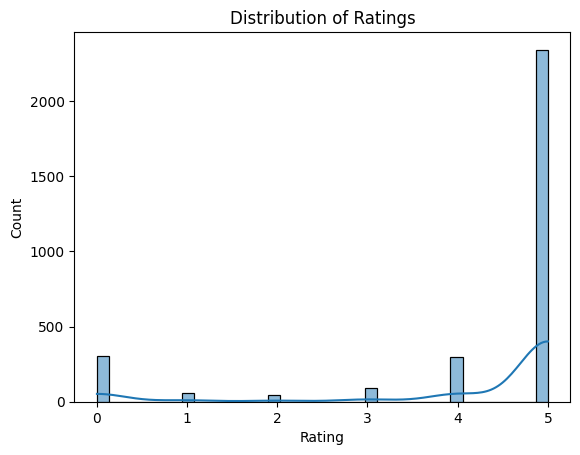

In [5]:
# EDA
# Distribution of 'Rating'
sns.histplot(data['Rating'], kde=True)
plt.title('Distribution of Ratings')
plt.show()

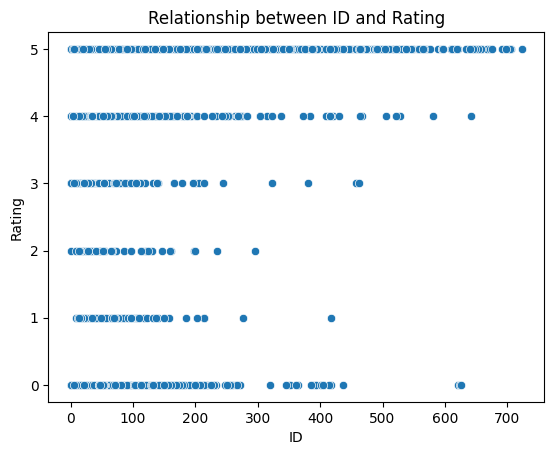

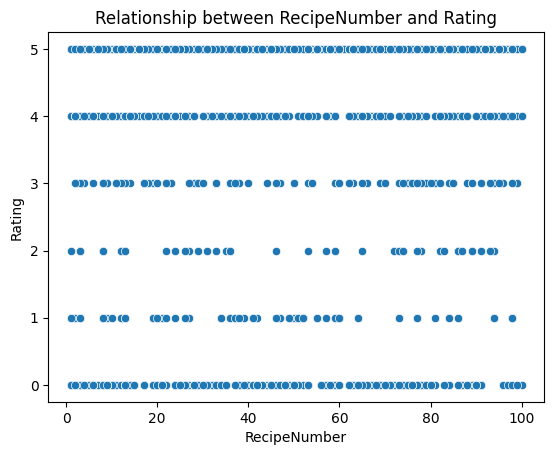

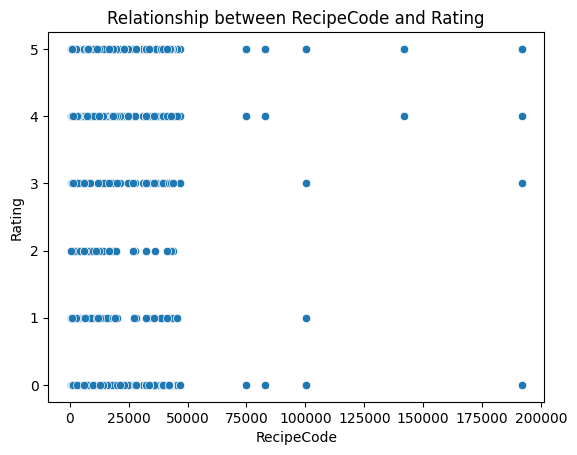

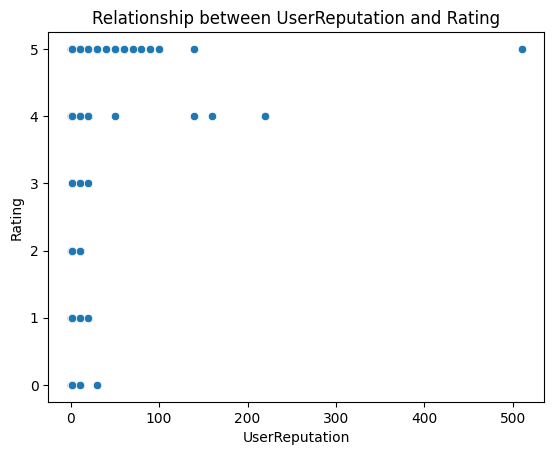

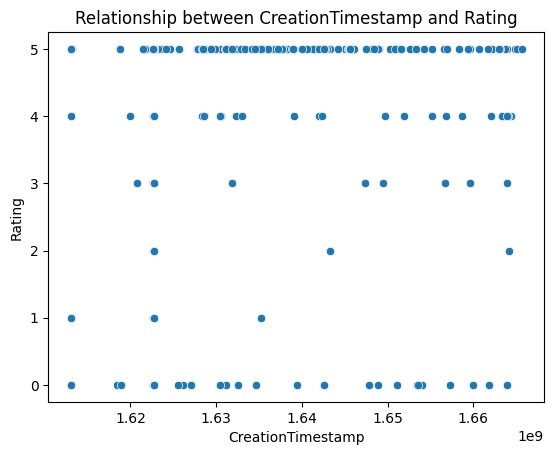

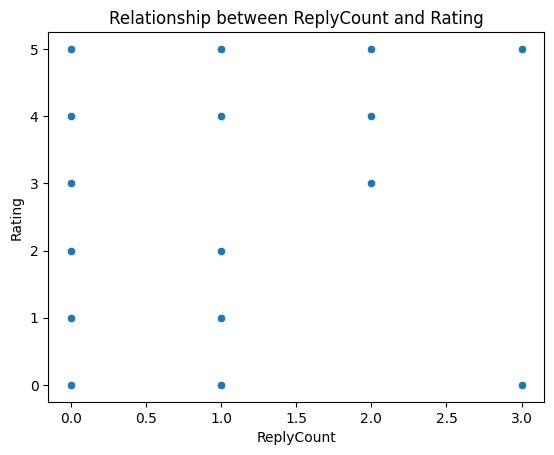

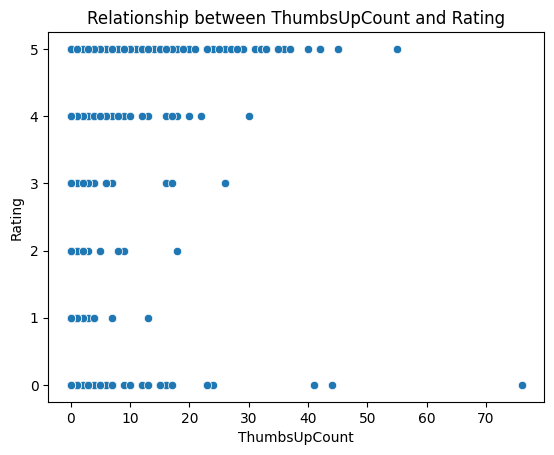

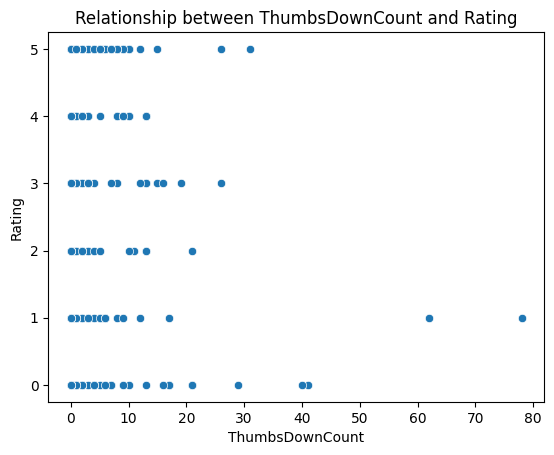

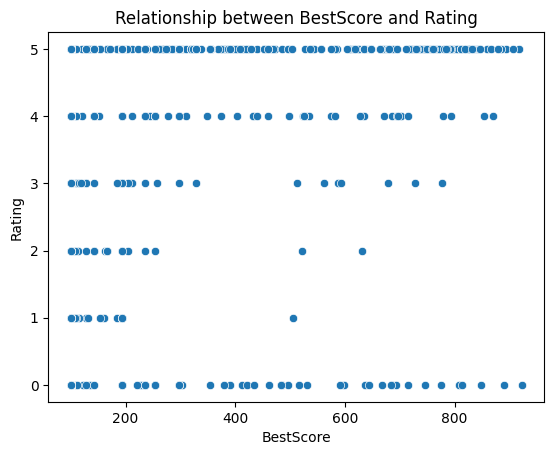

In [6]:
# Relationship between features and the rating
for col in numeric_features:
    sns.scatterplot(x=data[col], y=data['Rating'])
    plt.title(f'Relationship between {col} and Rating')
    plt.show()

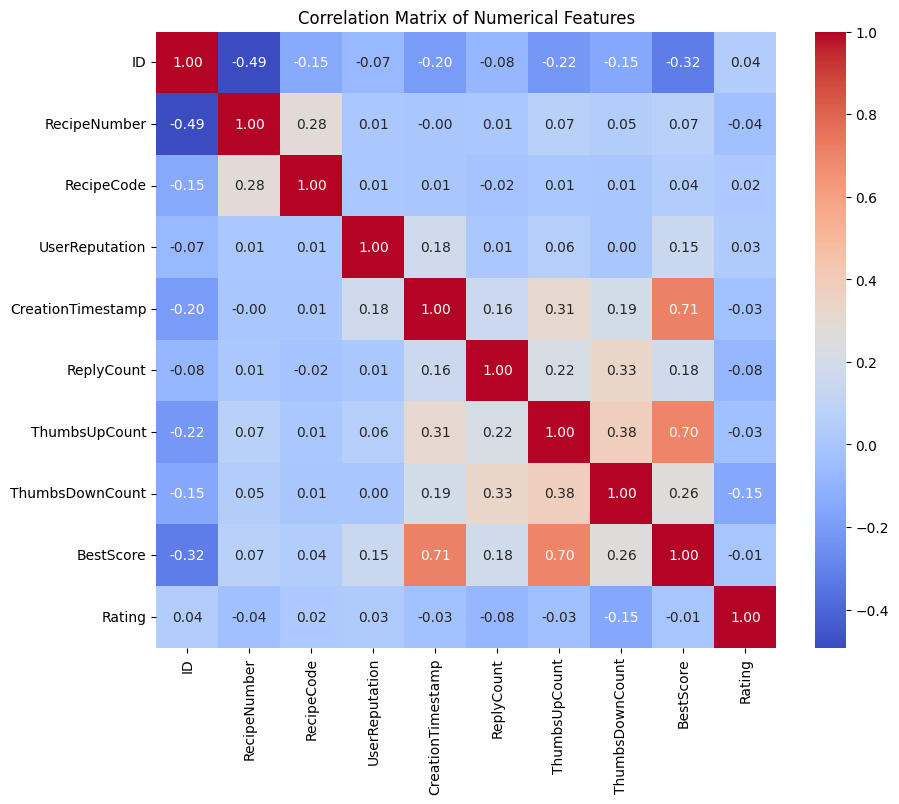

In [8]:
# Plotting the correlation matrix for numerical features
numerical_data = data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [10]:
# NLP Preprocessing on 'Recipe_Review'
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to 'Recipe_Review'
data = data[data['Recipe_Review'].notna()]  # Remove rows with missing values (NaN)
data = data[data['Recipe_Review'].str.isdecimal() == False]  # Remove rows with only decimal values
data['Processed_Recipe_Review'] = data['Recipe_Review'].apply(preprocess_text)

# Display the first few processed text entries
print(data[['Recipe_Review', 'Processed_Recipe_Review']].head())

                                       Recipe_Review  \
0  great recipe! I have made them just as written...   
1  This is an easy and quick recipe that is great...   
2  I think I was looking for something extra spec...   
3  This is our favorite grilled chicken recipe.  ...   
4  Great basic recipe. I added 2 teaspoons Tuscan...   

                             Processed_Recipe_Review  
0  [great, recipe, made, written, wonderfull, moi...  
1  [easy, quick, recipe, great, fall, cool, weath...  
2  [think, looking, something, extra, special, so...  
3  [favorite, grilled, chicken, recipe, great, fl...  
4  [great, basic, recipe, added, 2, teaspoons, tu...  


Most common words: [('recipe', 1726), ('made', 1077), ('make', 984), ('used', 736), ('good', 649), ('time', 522), ('delicious', 515), ('great', 512), ('added', 466), ('easy', 459)]


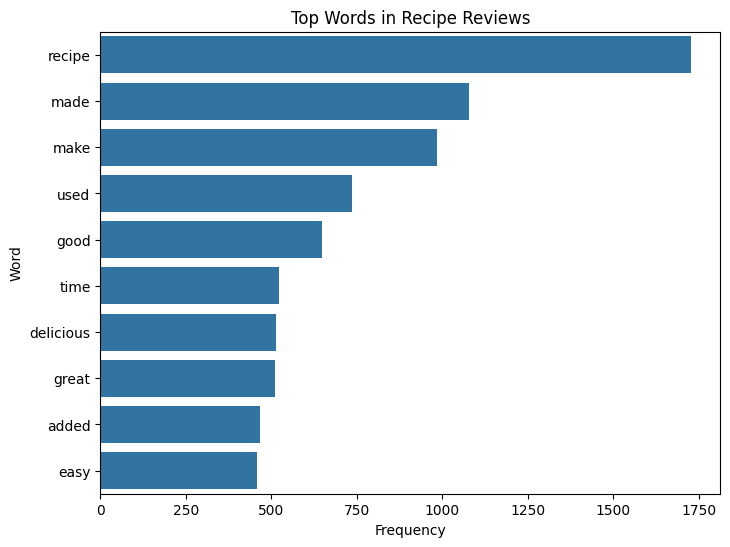

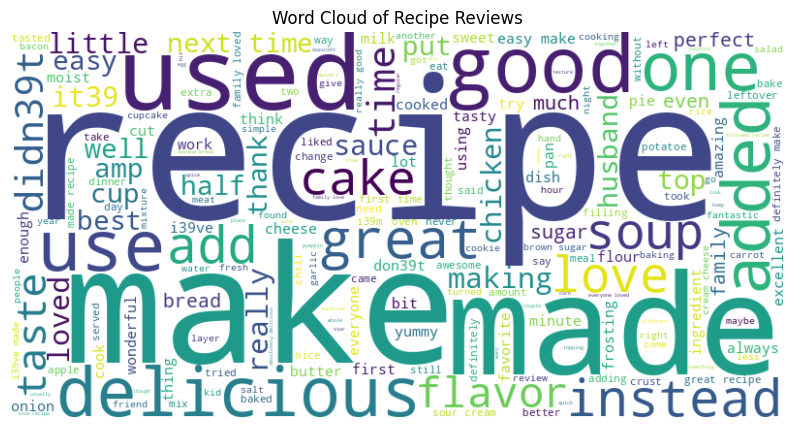

In [12]:
# Visualize the most common words after preprocessing
all_words = [word for tokens in data['Processed_Recipe_Review'] for word in tokens]
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(10)
print("Most common words:", most_common_words)

words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='Frequency', y='Word', data=words_df, ax=ax)
ax.set_title('Top Words in Recipe Reviews')
plt.show()

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Recipe Reviews')
plt.show()

In [13]:
# Prepare data for modeling
X = data.drop('Rating', axis=1)
y = data['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Pipeline and Model Training
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Try different models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

grid_search_models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Grid search for model tuning
param_grid = {
    'Ridge Regression': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso Regression': {'model__alpha': [0.1, 1.0, 10.0]},
    'Random Forest': {'model__n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.05, 0.1, 0.2]},
    'Support Vector Regression': {'model__C': [1, 10, 100], 'model__gamma': ['scale', 'auto']}
}


for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    grid_search_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    if(name != 'Linear Regression'):
        grid_search = GridSearchCV(grid_search_pipeline, param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        print(f'\nBest parameters for {name}: {grid_search.best_params_}')
        predictions = grid_search.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f'{name} - MSE: {mse},\tR2 Score: {r2}')
    else:
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        print(f'{name} MSE: {mse}')


Linear Regression MSE: 2.577739957874028

Best parameters for Ridge Regression: {'model__alpha': 1.0}
Ridge Regression - MSE: 2.566203766790227,	R2 Score: 0.06603246365191096

Best parameters for Lasso Regression: {'model__alpha': 0.1}
Lasso Regression - MSE: 2.704187624119073,	R2 Score: 0.015813363768654165

Best parameters for Random Forest: {'model__n_estimators': 200}
Random Forest - MSE: 2.95435678913738,	R2 Score: -0.07523547722601598

Best parameters for Gradient Boosting: {'model__learning_rate': 0.2, 'model__n_estimators': 100}
Gradient Boosting - MSE: 2.5319475263567113,	R2 Score: 0.07849999132694696

Best parameters for Support Vector Regression: {'model__C': 100, 'model__gamma': 'scale'}
Support Vector Regression - MSE: 2.667704691153543,	R2 Score: 0.029091294173684945
